# 0. Dependecies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%script false --no-raise-error
! unzip '/content/drive/MyDrive/Colab_Notebooks/CS504/final/data/archive.zip' -d '/content/drive/MyDrive/Colab_Notebooks/CS504/final/data/mineral_dataset'

In [3]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 57.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [4]:
import sys
from pathlib import Path
import datetime
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers.legacy import SGD, Adam
from tensorflow.keras.applications import vgg16
from matplotlib import pyplot as plt

import keras
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dropout, Dense

import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
import csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from art.attacks.evasion import BoundaryAttack, ProjectedGradientDescent, NewtonFool, DeepFool
from art.estimators.classification import KerasClassifier, TensorFlowV2Classifier
from art.estimators import KerasEstimator
from art.attacks.poisoning.perturbations import add_single_bd, insert_image
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.utils import to_categorical

import imageio

import pandas as pd

from distutils.dir_util import copy_tree
import imghdr
from PIL import Image


In [5]:
#%%script false --no-raise-error
# This line is important, without it the attacks in the ART toolbox won't work
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

TensorFlow version:2.12.0
Keras version:2.12.0


In [6]:
data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/final/data"

# 1. Data preparation

## 1.1 Data exploration

In [ ]:
label_list = ['biotite', 'bornite', 'chrysocolla', 'malachite', 'muscovite', 'pyrite', 'quartz']

dirs = []
for label in label_list:
    dir = os.path.join(data_path, 'new_dataset', label)
    dirs.append(dir)

print(dirs)

['/content/drive/MyDrive/Colab_Notebooks/CS504/final/data/new_dataset/biotite', '/content/drive/MyDrive/Colab_Notebooks/CS504/final/data/new_dataset/bornite', '/content/drive/MyDrive/Colab_Notebooks/CS504/final/data/new_dataset/chrysocolla', '/content/drive/MyDrive/Colab_Notebooks/CS504/final/data/new_dataset/malachite', '/content/drive/MyDrive/Colab_Notebooks/CS504/final/data/new_dataset/muscovite', '/content/drive/MyDrive/Colab_Notebooks/CS504/final/data/new_dataset/pyrite', '/content/drive/MyDrive/Colab_Notebooks/CS504/final/data/new_dataset/quartz']


In [ ]:
for data_dir in dirs:
    image_extensions = [".png", ".jpg"]  # add there all your images file extensions
    img_type_accepted_by_tf = ["bmp", "jpeg", "png"]
    for filepath in Path(data_dir).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                os.remove(filepath) 
                # print(f"{filepath} is not an image")
        elif imghdr.what(filepath) not in img_type_accepted_by_tf:
            im = Image.open(filepath).convert('RGB')
            im.save(filepath, "jpeg")
            print(filepath)
            os.remove(filepath) 
            # print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

/content/drive/MyDrive/Colab_Notebooks/CS504/final/data/new_dataset/bornite/C2_02_00.gif
/content/drive/MyDrive/Colab_Notebooks/CS504/final/data/new_dataset/chrysocolla/C3_03_534.gif


In [ ]:
# count images per label

def labeles_counter(main_fold_path):

    dict_counter = {}
    for dir, subdir, files in os.walk(main_fold_path):
        if 'omit' in dir:
            continue
        if len(files) > 0:
           
            if os.path.basename(dir) not in dict_counter:
                dict_counter[os.path.basename(dir)] = 0

            dict_counter[os.path.basename(dir)] += len(files)

    return dict_counter

In [ ]:
dataset_path = os.path.join(data_path, 'new_dataset')
dict_counter = labeles_counter(dataset_path)
#del dict_counter["dataset"]
dict_counter

{'biotite': 1069,
 'bornite': 414,
 'chrysocolla': 535,
 'malachite': 981,
 'muscovite': 344,
 'pyrite': 1071,
 'quartz': 1168}

In [ ]:
labels = dict_counter.keys()
count = dict_counter.values()

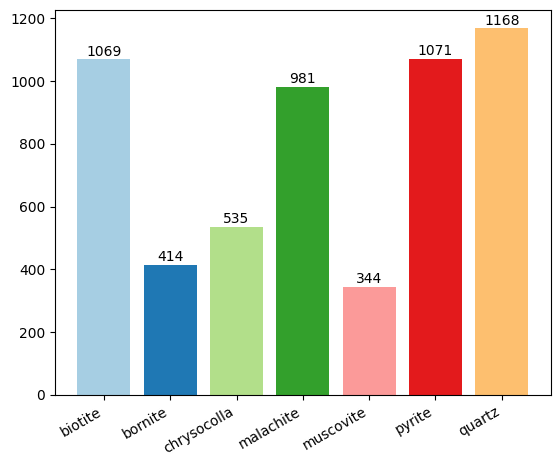

In [ ]:
fig, ax = plt.subplots()

fig.set_figheight(5)

my_cmap = plt.get_cmap("Paired")
pps = ax.bar(list(labels), count, align='center', color=my_cmap.colors)
plt.xticks(rotation=30, ha='right')

for p in pps:
   height = p.get_height()
   ax.text(x=p.get_x() + p.get_width() / 2, y=height+12,
      s=height,
      ha='center')
plt.show()

In [ ]:
#%%script false --no-raise-error
# Delete .ipynb_checkpoints directory
checkpoints_dir = os.path.join(data_dir, '.ipynb_checkpoints')
if os.path.exists(checkpoints_dir):
    os.system(f'rm -rf {checkpoints_dir}')

# BATCH_SIZE = 64
# IMG_SIZE = (256, 256)

# train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
#                                                             shuffle=True,
#                                                              validation_split=0.2,
#                                                             subset="training",
#                                                             seed=99,
#                                                             batch_size=BATCH_SIZE,
#                                                             image_size=IMG_SIZE)

In [ ]:
# Function to load the images and the labels from the dataset
# extract_path = data_path
def load_images_and_labels(directory):
    #directory = os.path.join(extract_path, directory)
    imgs_list = []
    labels_list = []
    label_dict = {}

    # List of all subfolders in the directory
    subfolders_list_1 = listdir(directory)
    # Make sure that the subfolders are sorted 
    subfolders_list = natsort.natsorted(subfolders_list_1)

    # Assign a label to each folder with images (0 to the first folder)
    lab = 0
    for subfolder_name in subfolders_list:
            sub_dir_path = os.path.join(directory, subfolder_name)
            if subfolder_name == '.DS_Store':
                continue
            if subfolder_name == 'omit':
                continue
            # Read the images as numpy arrays
            if lab not in label_dict:
                label_dict[lab] = subfolder_name 
                
            imagesList = listdir(sub_dir_path)
            for i in range(len(imagesList)):
                tmp_img = cv2.imread(os.path.join(sub_dir_path, imagesList[i]))
                if not os.path.isfile(os.path.join(sub_dir_path, imagesList[i])):
                    print(f"File does not exist: {imagesList[i]}")
                    print(os.path.join(sub_dir_path, imagesList[i]))
                    continue
                # Resize all images to 256 x 256 pixels
                #print(os.path.join(sub_dir_path, imagesList[i]))
                resized_img = cv2.resize(tmp_img, (128, 128)) 
                img_arr = np.array(resized_img)
                imgs_list.append(img_arr/255.)
                labels_list.append(lab)
            lab += 1
    
    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)
    labels = np.asarray(labels_list)
    print(label_dict)

    return imgs, labels

# Use the above function to load the training and test datasets
dataset_path = os.path.join(data_path, 'new_dataset')
all_images, all_labels = load_images_and_labels(dataset_path)

{0: 'biotite', 1: 'bornite', 2: 'chrysocolla', 3: 'malachite', 4: 'muscovite', 5: 'pyrite', 6: 'quartz'}


In [ ]:
#%%script false --no-raise-error
# save images
img_export_path = os.path.join(data_path, "all_images.npy")

In [ ]:
#%%script false --no-raise-error
# save labels
label_export_path = os.path.join(data_path, "all_labels.npy")

In [ ]:
np.save(img_export_path, all_images)
np.save(label_export_path, all_labels)

## 1.2 load the data

In [ ]:
labels_dict = {0: 'biotite', 1: 'bornite', 2: 'chrysocolla', 3: 'malachite', 4: 'muscovite', 5: 'pyrite', 6: 'quartz'}

In [ ]:
# load imgs and labels
all_images = np.load(os.path.join(data_path, "all_images.npy"))
all_labels = np.load(os.path.join(data_path, "all_labels.npy"))

In [ ]:
# Split into train, test, and validation sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=160)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=22966)
del all_images, trainval_images

In [ ]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images 
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (3572, 128, 128, 3) - Labels train shape: (3572,)
Images validation shape: (893, 128, 128, 3) - Labels validation shape: (893,)
Images test shape: (1117, 128, 128, 3) - Labels test shape: (1117,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.4877579729195972
Data type float64


In [ ]:
# train_labels_onehot = keras.utils.to_categorical(train_labels, 7)
# test_labels_onehot = keras.utils.to_categorical(test_labels, 7)
# val_labels_onehot = keras.utils.to_categorical(val_labels, 7)

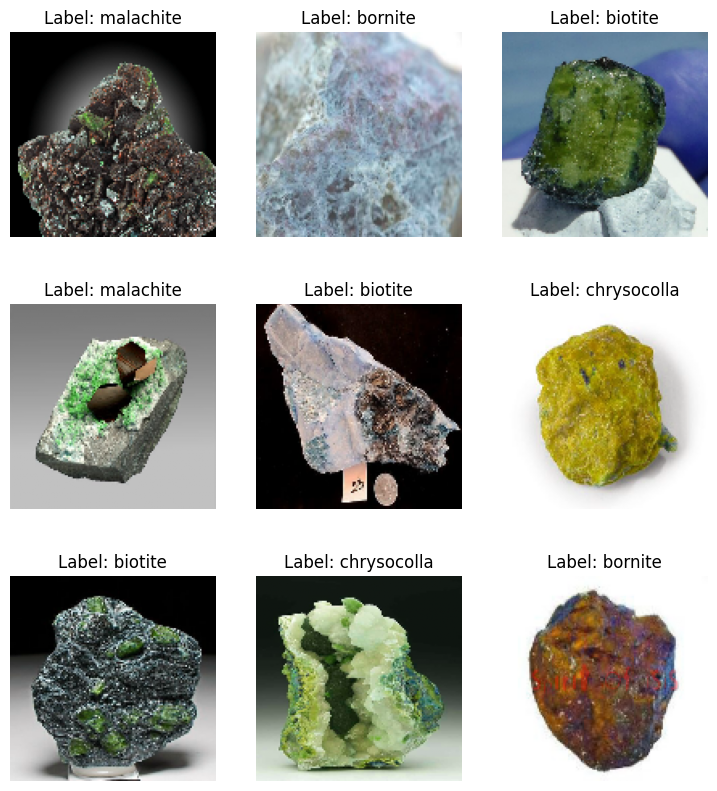

In [ ]:
# A list with the names of the image classes
               
# Plot a few images to check if the labels make sense
#labels_dict = {0: 'biotite', 1: 'bornite', 2: 'chrysocolla', 3: 'malachite', 4: 'muscovite', 5: 'pyrite', 6: 'quartz'}
plt.figure(figsize=(9, 10))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]].astype(float))
    plt.title('Label: ' + str(labels_dict[train_labels[i[0]]]))
    plt.axis('off')

## 1.3 data augmentation

In [ ]:
# Convert them to Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [ ]:
# Now let's apply prefetch to datasets
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.batch(64).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.batch(64).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Define data augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.4),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomZoom(.5, .2),
  tf.keras.layers.GaussianNoise(0.1)
  ])

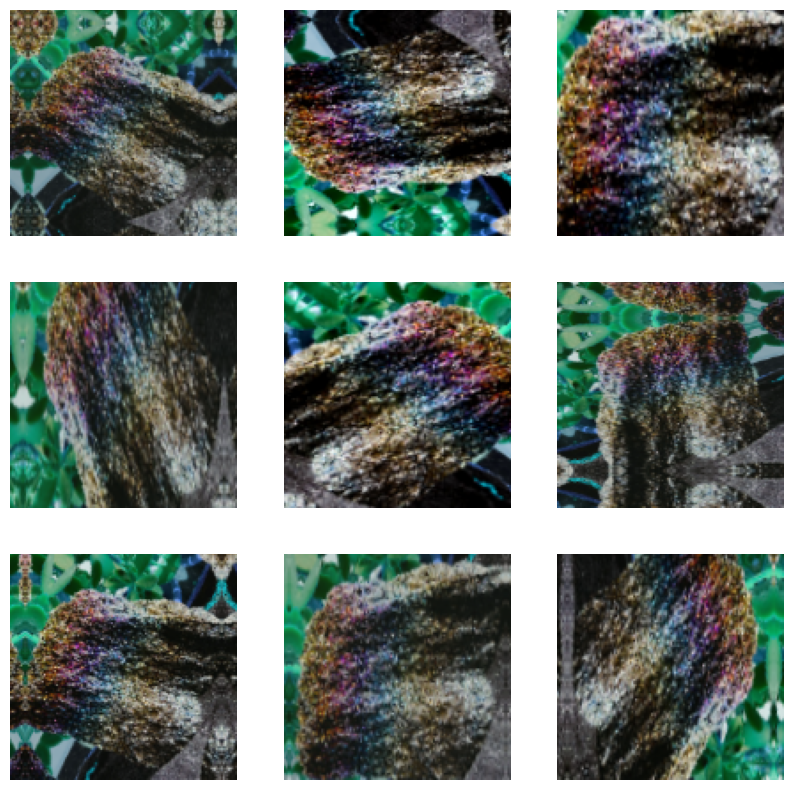

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        #plt.imshow(augmented_image[0])
        plt.imshow(augmented_image[0].numpy().astype("float64"))
        #plt.title('Label: ' + str(labels_dict[train_labels[i]]))
        plt.axis('off')

# 2. Train the model

In [ ]:
# Define the base model - replace this with the base model you are using
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Create the model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')

inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = base_model(x)#, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(1024)(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(512)(x)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
           #tf.keras.callbacks.ReduceLROnPlateau(patience=2, min_delta=0.001)
           ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7, verbose=1)
           ]
           
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
class_weights = {0:(1/1069)*(5640/7) , 1:(1/414)*(5640/7) , 2:(1/535)*(5640/7) , 3:(1/981)*(5640/7)\
                 , 4:(1/344)*(5640/7) , 5:(1/1071)*(5640/7) , 6:(1/1168)*(5640/7) }

In [ ]:
# Define the base model - replace this with the base model you are using
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Create the model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')

class DataAugmentationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DataAugmentationLayer, self).__init__()
        self.flip = tf.keras.layers.RandomFlip('horizontal')
        self.rotation = tf.keras.layers.RandomRotation(0.4)
        #self.contrast = tf.keras.layers.RandomContrast(0.2)
        self.zoom = tf.keras.layers.RandomZoom(.5, .2)
        self.noise = tf.keras.layers.GaussianNoise(0.1)

    def call(self, inputs, training=True):
        x = self.flip(inputs, training=training)
        x = self.rotation(x, training=training)
        #x = self.contrast(x, training=training)
        x = self.zoom(x, training=training)
        x = self.noise(x, training=training)
        return x

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),
    DataAugmentationLayer(),
    base_model,
    global_average_layer,
    tf.keras.layers.Dropout(0.2),
    prediction_layer
])

callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
           #tf.keras.callbacks.ReduceLROnPlateau(patience=2, min_delta=0.001)
           ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7, verbose=1)
           ]
           
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
class_weights = {0:(1/1069)*(5640/7) , 1:(1/414)*(5640/7) , 2:(1/535)*(5640/7) , 3:(1/981)*(5640/7)\
                 , 4:(1/344)*(5640/7) , 5:(1/1071)*(5640/7) , 6:(1/1168)*(5640/7) }

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
# Get a single batch of images and labels
images, labels = next(iter(train_dataset.take(1)))

# Print the shape of the first image
print(images[0].shape)

(128, 128, 3)


In [ ]:
images, labels = next(iter(train_dataset.take(1)))
print(model.predict(tf.expand_dims(images[0], 0)))

1/1 [==============================] - 2s 2s/step
[[0.15410064 0.07089768 0.27889407 0.13400379 0.19446653 0.11761617
  0.05002108]]


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation_layer (Da  (None, 128, 128, 3)      0         
 taAugmentationLayer)                                            
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 20,875,823
Trainable params: 9,492,687
Non

In [ ]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks=callbacks,
                    class_weight=class_weights
                   )

Epoch 1/30
56/56 [==============================] - 37s 219ms/step - loss: 1.5264 - accuracy: 0.4381 - val_loss: 2.8909 - val_accuracy: 0.4345 - lr: 0.0010
Epoch 2/30
56/56 [==============================] - 8s 148ms/step - loss: 1.1125 - accuracy: 0.6022 - val_loss: 1.4703 - val_accuracy: 0.5756 - lr: 0.0010
Epoch 3/30
56/56 [==============================] - 8s 149ms/step - loss: 0.9299 - accuracy: 0.6727 - val_loss: 1.3938 - val_accuracy: 0.5745 - lr: 0.0010
Epoch 4/30
56/56 [==============================] - 8s 149ms/step - loss: 0.7740 - accuracy: 0.7242 - val_loss: 1.5344 - val_accuracy: 0.5901 - lr: 0.0010
Epoch 5/30
56/56 [==============================] - 8s 151ms/step - loss: 0.6950 - accuracy: 0.7590 - val_loss: 1.1269 - val_accuracy: 0.6753 - lr: 0.0010
Epoch 6/30
56/56 [==============================] - 8s 151ms/step - loss: 0.5924 - accuracy: 0.7954 - val_loss: 1.0937 - val_accuracy: 0.6909 - lr: 0.0010
Epoch 7/30
56/56 [==============================] - 9s 153ms/step - l

In [ ]:
model_name = "mineral_imagenet_s.h5"
model_path = os.path.join(data_path, 'model', model_name)
print(model_path)

/content/drive/MyDrive/Colab_Notebooks/CS504/final/data/model/mineral_imagenet_s.h5


In [ ]:
#save the model
save_model(model, model_path)
#model.save(model_path)

#save our history so we dont lose it.
np.save(os.path.join(data_path, 'model', "mineral_imagenet_s_HistoryDict.npy"), history.history)

In [ ]:
class DataAugmentationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DataAugmentationLayer, self).__init__()
        self.flip = tf.keras.layers.RandomFlip('horizontal')
        self.rotation = tf.keras.layers.RandomRotation(0.4)
        #self.contrast = tf.keras.layers.RandomContrast(0.2)
        self.zoom = tf.keras.layers.RandomZoom(.5, .2)
        self.noise = tf.keras.layers.GaussianNoise(0.1)

    def call(self, inputs, training=True):
        x = self.flip(inputs, training=training)
        x = self.rotation(x, training=training)
        #x = self.contrast(x, training=training)
        x = self.zoom(x, training=training)
        x = self.noise(x, training=training)
        return x

# Register the custom object for deserialization
tf.keras.utils.get_custom_objects()["DataAugmentationLayer"] = DataAugmentationLayer

# Load the model within the custom object scope
with tf.keras.utils.custom_object_scope({"DataAugmentationLayer": DataAugmentationLayer}):
    loaded_model = tf.keras.models.load_model(os.path.join(data_path, 'model', "mineral_imagenet_s.h5"))

In [ ]:
t = datetime.datetime.now()
evals_test = loaded_model.evaluate(test_images, test_labels)
print("Classification Accuracy Test: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = loaded_model.evaluate(val_images, val_labels)
print("Classification Accuracy Validation: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = loaded_model.evaluate(train_images, train_labels)
print("Classification Accuracy Train: ", evals_test[1])
print('Inference time: %s' % (datetime.datetime.now() - t))

35/35 [==============================] - 4s 58ms/step - loss: 0.9135 - accuracy: 0.7269
Classification Accuracy Test:  0.7269471883773804
Inference time: 0:00:04.072504 

28/28 [==============================] - 1s 42ms/step - loss: 0.9588 - accuracy: 0.7346
Classification Accuracy Validation:  0.7346024513244629
Inference time: 0:00:01.588548 

112/112 [==============================] - 5s 47ms/step - loss: 0.6425 - accuracy: 0.7990
Classification Accuracy Train:  0.7989921569824219
Inference time: 0:00:06.641916


In [ ]:
def plot_acc_loss(HISTORY):
    # Plot the loss and accuracy
    train_loss = HISTORY['loss']
    val_loss = HISTORY['val_loss']
    acc = HISTORY['accuracy'] 
    val_acc = HISTORY['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # fig_name1 = "task1_loss.png"
    # fig_saving_path = os.path.join(PROJECT_ROOT_DIR, figure_dir)
    # if not os.path.exists(fig_saving_path):
    #    os.makedirs(fig_saving_path)

    # plt.savefig(os.path.join(fig_saving_path, fig_name1))

    axes = plt.gca()

    plt.figure()
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    #fig_name2 = "task1_accuracy.png"
    #plt.savefig(os.path.join(fig_saving_path, fig_name2))

    plt.show()

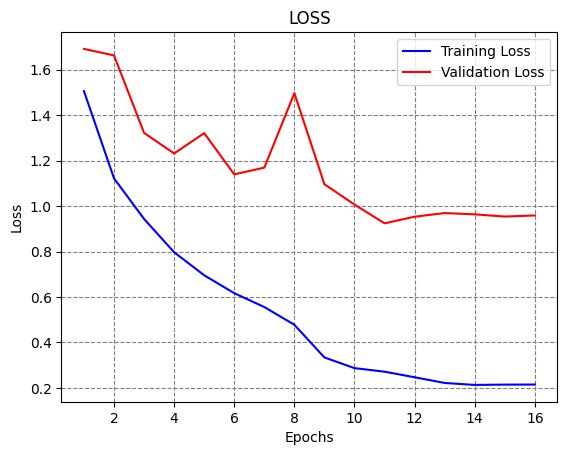

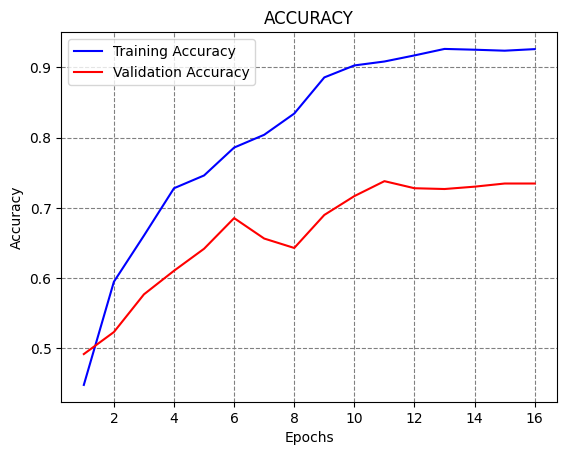

In [ ]:
history = np.load(os.path.join(data_path, 'model', "mineral_imagenet_s_HistoryDict.npy"),allow_pickle=True).item()
plot_acc_loss(history)

# 3. Apply the attacks

## 3.1 Load the model and data

In [7]:
class DataAugmentationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DataAugmentationLayer, self).__init__()
        self.flip = tf.keras.layers.RandomFlip('horizontal')
        self.rotation = tf.keras.layers.RandomRotation(0.4)
        #self.contrast = tf.keras.layers.RandomContrast(0.2)
        self.zoom = tf.keras.layers.RandomZoom(.5, .2)
        self.noise = tf.keras.layers.GaussianNoise(0.1)

    def call(self, inputs, training=True):
        x = self.flip(inputs, training=training)
        x = self.rotation(x, training=training)
        #x = self.contrast(x, training=training)
        x = self.zoom(x, training=training)
        x = self.noise(x, training=training)
        return x

# Register the custom object for deserialization
tf.keras.utils.get_custom_objects()["DataAugmentationLayer"] = DataAugmentationLayer

# Load the model within the custom object scope
with tf.keras.utils.custom_object_scope({"DataAugmentationLayer": DataAugmentationLayer}):
    loaded_model = tf.keras.models.load_model(os.path.join(data_path, 'model', "mineral_imagenet_s.h5"))

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
classifier = KerasClassifier(model=loaded_model, clip_values=(0, 1))

In [ ]:
labels_dict = {0: 'biotite', 1: 'bornite', 2: 'chrysocolla', 3: 'malachite', 4: 'muscovite', 5: 'pyrite', 6: 'quartz'}

In [9]:
# load imgs and labels
all_images = np.load(os.path.join(data_path, "all_images.npy"))
all_labels = np.load(os.path.join(data_path, "all_labels.npy"))

In [10]:
# Split into train, test, and validation sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=160)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=22966)
del all_images, trainval_images

In [ ]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images 
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (3572, 128, 128, 3) - Labels train shape: (3572,)
Images validation shape: (893, 128, 128, 3) - Labels validation shape: (893,)
Images test shape: (1117, 128, 128, 3) - Labels test shape: (1117,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.4877579729195972
Data type float64


In [ ]:
# train_labels_onehot = keras.utils.to_categorical(train_labels, 7)
# test_labels_onehot = keras.utils.to_categorical(test_labels, 7)
# val_labels_onehot = keras.utils.to_categorical(val_labels, 7)

In [ ]:
#y_test_onehot = keras.utils.to_categorical(y_test, 7)

In [11]:
test_labels_ex =  np.expand_dims(test_labels, axis=1)
print(test_labels_ex.shape)

(1117, 1)


In [12]:
# Randomly select 1000 records from the test dataset
np.random.seed(42)
indices = np.random.choice(test_images.shape[0], size=100, replace=False)
X_test_subset = test_images[indices]
y_test_subset = test_labels_ex[indices]

## 3.2 Four adversarial attack experiments

In [ ]:
from art.attacks.evasion import BasicIterativeMethod, SimBA, UniversalPerturbation, GeoDA

### 3.2.1 BasicIterativeMethod

**Model Introduction**:

The Basic Iterative Method (BIM) Attack is a type of adversarial attack that aims to fool machine learning models, particularly those based on neural networks. BIM is an iterative version of the Fast Gradient Sign Method (FGSM), another adversarial attack. In the BIM attack, the FGSM is applied multiple times with small step size, and after each step, the perturbed sample is clipped to ensure that it stays in an ε-neighbourhood of the original sample. This process helps to produce more effective adversarial examples than a single-step method.

In the experiment, we are applying the BIM attack on a classifier with varying levels of perturbation magnitudes (ε) set as [0.01, 0.05, 0.2]. We generate adversarial examples for a subset of the test data (X_test_subset), and then evaluate the classifier's performance on these adversarial examples in terms of accuracy and average perturbation. The accuracy is calculated as the proportion of correctly predicted labels, while the average perturbation measures the mean absolute difference between the adversarial examples and the original test data. For each ε, we also save the first 3 adversarial examples along with their original and predicted labels for further analysis and visualization.

In [ ]:
epsilons = [0.01, 0.05, 0.2]
adversarial_images = []
original_labels = []
predicted_labels = []
original_images = []

for epsilon in epsilons:
    attacker_bim = BasicIterativeMethod(estimator=classifier, eps=epsilon)
    X_test_adv_bim = attacker_bim.generate(x=X_test_subset)

    # Save the first 3 adversarial images
    adversarial_images.append(X_test_adv_bim[:3])
    original_images.append(X_test_subset[:3])
    original_labels.append(y_test_subset[:3])

    # Generate and save the predictions for the first 3 adversarial images
    predictions_bim = classifier.predict(X_test_adv_bim[:3])
    predicted_labels.append(predictions_bim)

    # Evaluate the model on the adversarial test examples
    accuracy_bim = np.sum(np.argmax(predictions_bim, axis=1) == np.argmax(y_test_subset[:3], axis=1)) / len(y_test_subset[:3])
    avg_perturbation_bim = np.mean(np.abs((X_test_adv_bim - X_test_subset)))

    print(f'Basic Iterative Method Attack with epsilon={epsilon}: Test Accuracy: {accuracy_bim}, Average Perturbation: {avg_perturbation_bim}')

# Convert lists to numpy arrays
adversarial_images = np.array(adversarial_images)
original_labels = np.array(original_labels)
predicted_labels = np.array(predicted_labels)
original_images = np.array(original_images)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Basic Iterative Method Attack with epsilon=0.01: Test Accuracy: 0.0, Average Perturbation: 0.009432908932185121


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Basic Iterative Method Attack with epsilon=0.05: Test Accuracy: 0.0, Average Perturbation: 0.04587359853362182


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Basic Iterative Method Attack with epsilon=0.2: Test Accuracy: 0.0, Average Perturbation: 0.11330208474594604


**Result Analysis**:

The Basic Iterative Method (BIM) attack has shown high effectiveness against the classifier trained on the mineral image dataset, as evidenced by the drastic reduction in test accuracy to 0% across all tested epsilon values. BIM operates by applying small perturbations repeatedly, which gradually accumulates and leads to a significant change in the model's predictions. This method's strength lies in its ability to create adversarial examples that are hard for the model to classify correctly, while being virtually indistinguishable from the original images to the human eye. The increase in average perturbation as epsilon rises also indicates that the attack becomes more potent with a larger allowable perturbation.

However, the effectiveness of the BIM attack also highlights potential vulnerabilities in the model's learning mechanism. The model appears to be highly sensitive to the perturbations introduced by the BIM attack, suggesting that it might have overfitted to the training data and failed to generalize well to slightly modified inputs. Moreover, while BIM is powerful, it requires access to the model's gradients, which might not always be available, especially in a black-box setting. These results underscore the importance of incorporating robustness and generalization in the model training process, such as adversarial training or regularization techniques, to improve the model's resilience against adversarial attacks.

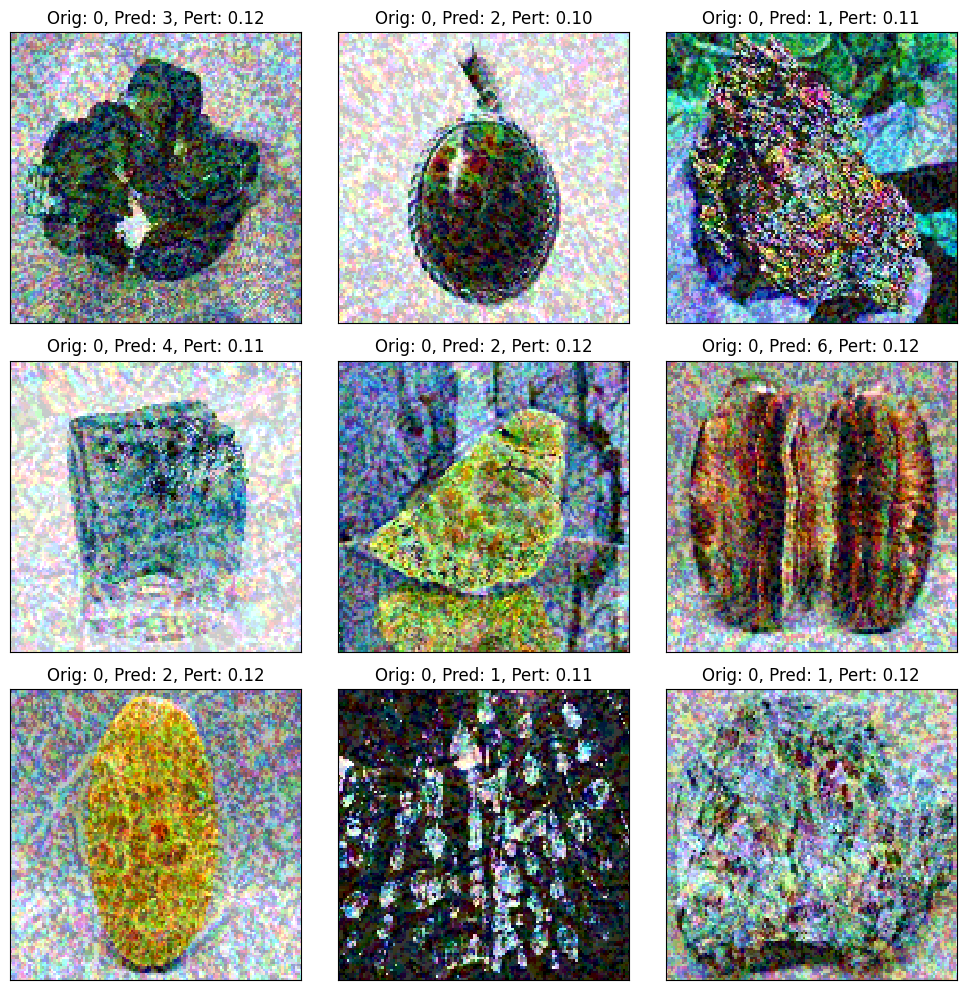

In [ ]:
def plot_attacked_images_ex(ADV_IMG, original_images, original_labels, predicted_labels):
    # Select first 9 adversarial examples
    examples_bim = ADV_IMG[:9]
    original_examples = original_images[:9]
    original_labels = np.argmax(original_labels[:9], axis=1)
    predicted_labels = np.argmax(predicted_labels[:9], axis=1)

    # Create a new figure
    plt.figure(figsize=(10, 10))

    # Loop over the examples and plot them
    for i in range(9):
        # Create a new subplot for each image
        plt.subplot(3, 3, i + 1)
        
        # Remove x and y axis ticks
        plt.xticks([])
        plt.yticks([])
        
        # Calculate perturbation
        perturbation = np.abs((ADV_IMG[i] - original_examples[i]))

        # Display the image
        plt.imshow(examples_bim[i], interpolation='nearest')

        # Display the original and predicted labels as well as the perturbation
        plt.title(f"Orig: {original_labels[i]}, Pred: {predicted_labels[i]}, Pert: {np.mean(perturbation):.2f}")

    # Show the plot
    plt.tight_layout()
    plt.show()

# Generate predictions for first 9 adversarial images
predictions_bim = classifier.predict(X_test_adv_bim[:9])

plot_attacked_images_ex(X_test_adv_bim, X_test_subset, y_test_subset, predictions_bim)


### 3.2.2 Simple Black-box Adversarial Attack

**Model Introduction**:

The Simple Black-box Adversarial (SimBA) attack is an adversarial attack method designed to exploit machine learning models, particularly deep neural networks, without requiring access to their internals or gradients. This makes SimBA particularly effective against black-box models where such information is not available. SimBA generates adversarial samples by iteratively perturbing individual input features in either pixel or DCT (Discrete Cosine Transform) space, until the model's prediction changes.

In the experiment, the SimBA attack is configured with specific parameters. The attack parameter is set to 'dct', meaning that the attack will be conducted in the DCT space. The max_iter parameter is set to 3000, specifying the maximum number of iterations the attack will run. The order parameter is set to 'random', indicating that the features to be perturbed will be selected randomly. The epsilon parameter is set to 0.1, controlling the maximum perturbation applied to each feature. The freq_dim and stride parameters control the size and stride of the DCT blocks, and targeted is set to False, meaning this is an untargeted attack. Finally, batch_size is set to 1, meaning that the attack will process one sample at a time, and verbose is set to True, enabling detailed logging. After generating the adversarial samples, the model's performance is evaluated in terms of accuracy and average perturbation.

In [15]:
# Create the SimBA attacker
attacker_simba = SimBA(classifier=classifier, attack='dct', max_iter=3000, order='random', epsilon=0.1, freq_dim=4, stride=1, targeted=False, batch_size=1, verbose=True)

# Generate adversarial samples using the SimBA attacker
X_test_adv_simba = attacker_simba.generate(x=X_test_subset)

# Evaluate the model on the adversarial test examples
predictions_simba = classifier.predict(X_test_adv_simba)
accuracy_simba = np.sum(np.argmax(predictions_simba, axis=1) == np.argmax(y_test_subset, axis=1)) / len(y_test_subset)
avg_perturbation_simba = np.mean(np.abs((X_test_adv_simba - X_test_subset)))

print(f'SimBA Attack: Test Accuracy: {accuracy_simba}, Average Perturbation: {avg_perturbation_simba}')


SimBA - sample:   0%|          | 0/100 [00:00<?, ?it/s]

SimBA Attack: Test Accuracy: 0.22, Average Perturbation: 0.0005577858011558022


**Result Analysis**:

The Simple Black-box Adversarial (SimBA) attack has effectively reduced the classifier's test accuracy to 22% on the mineral image dataset, demonstrating its ability to generate adversarial examples that can mislead the model. SimBA operates without requiring knowledge about the model's internal structure or access to its gradients, which is a significant strength, particularly against black-box models. The reported small average perturbation also suggests that SimBA can produce changes that are nearly imperceptible to humans, while significantly affecting the classifier's performance.

However, SimBA's performance can be computationally intensive and time-consuming, particularly for larger datasets or more complex models, as it operates on individual input features and iterates until the model's prediction changes. The effectiveness of SimBA is also heavily reliant on the choice of parameters, such as the maximum perturbation and the number of iterations. These results highlight the importance of incorporating robustness measures, such as adversarial training, when building machine learning models to make them more resilient to adversarial attacks.

In [17]:
def plot_attacked_images(ADV_IMG):
    # Select first 9 adversarial examples
    examples_bim = ADV_IMG[:9]

    # Create a new figure
    plt.figure(figsize=(10, 10))

    # Loop over the examples and plot them
    for i in range(9):
        # Create a new subplot for each image
        plt.subplot(3, 3, i + 1)
        
        # Remove x and y axis ticks
        plt.xticks([])
        plt.yticks([])
        
        # Display the image
        plt.imshow(examples_bim[i], interpolation='nearest')

    # Show the plot
    plt.tight_layout()
    plt.show()


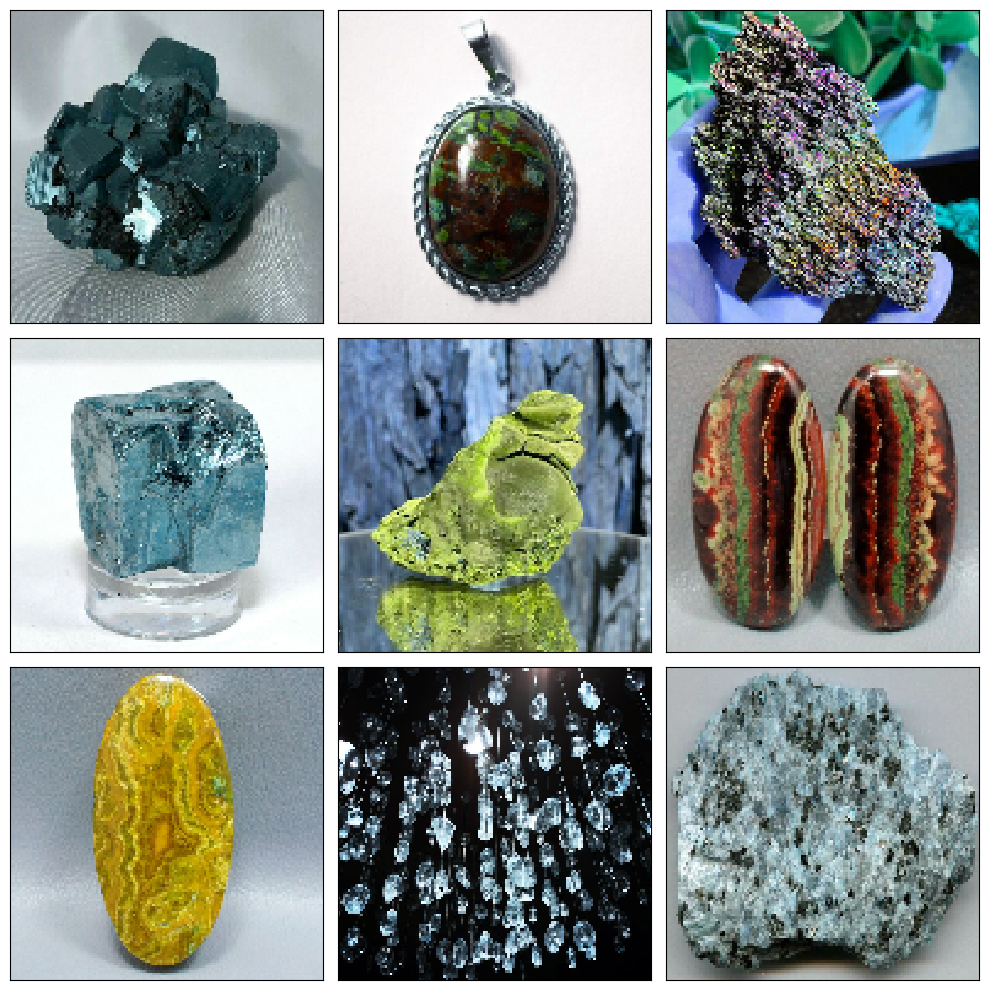

In [18]:
plot_attacked_images(X_test_adv_simba)

### 3.2.3 UniversalPerturbation

**Model Introduction**:

The Universal Perturbation attack is a type of adversarial attack designed to create a single, input-agnostic perturbation that, when applied to any input from a given dataset, is likely to cause a classifier to misclassify the perturbed input. This is different from most adversarial attacks, which generate unique perturbations tailored to each specific input. In the experiment, the classifier is the machine learning model to be attacked, and the perturbation is applied to the X_test_subset. After generating the adversarial examples, the code evaluates the classifier's accuracy on the perturbed test set and calculates the average magnitude of the perturbation.

In [ ]:
# Universal Perturbation Attack
attacker_uni = UniversalPerturbation(classifier=classifier)
X_test_adv_uni = attacker_uni.generate(x=X_test_subset)

# Evaluate the model on the adversarial test examples
predictions_uni = classifier.predict(X_test_adv_uni)
accuracy_uni = np.sum(np.argmax(predictions_uni, axis=1) == np.argmax(y_test_subset, axis=1)) / len(y_test_subset)
avg_perturbation_uni = np.mean(np.abs((X_test_adv_uni - X_test_subset)))

print(f'Universal Perturbation Attack: Test Accuracy: {accuracy_uni}, Average Perturbation: {avg_perturbation_uni}')

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Universal Perturbation Attack: Test Accuracy: 0.0, Average Perturbation: 0.25177806357945465


**Result Analysis**:

The Universal Perturbation Attack has shown a high degree of effectiveness against the classifier trained on the mineral image dataset. The test accuracy has been reduced to 0%, demonstrating that the universal perturbation was successful in misleading the classifier for all tested samples. The strength of this attack lies in its ability to create a single perturbation vector that can be used universally on any input data, hence its name. This quality makes the Universal Perturbation Attack a powerful tool as it does not require crafting individual perturbations for each instance, yet it still manages to cause significant misclassification.

However, the reported average perturbation is quite large (approximately 0.25), suggesting that the changes made to the images are potentially noticeable, which could be a drawback in situations where stealth is required. Furthermore, the effectiveness of this attack method also highlights potential vulnerabilities in the model's learning mechanism, indicating that the model might be overfitting to the training data and struggling to generalize to slightly modified inputs. This attack's success emphasizes the need for more robust training strategies, such as adversarial training, that can help improve the model's resilience against such adversarial attacks.

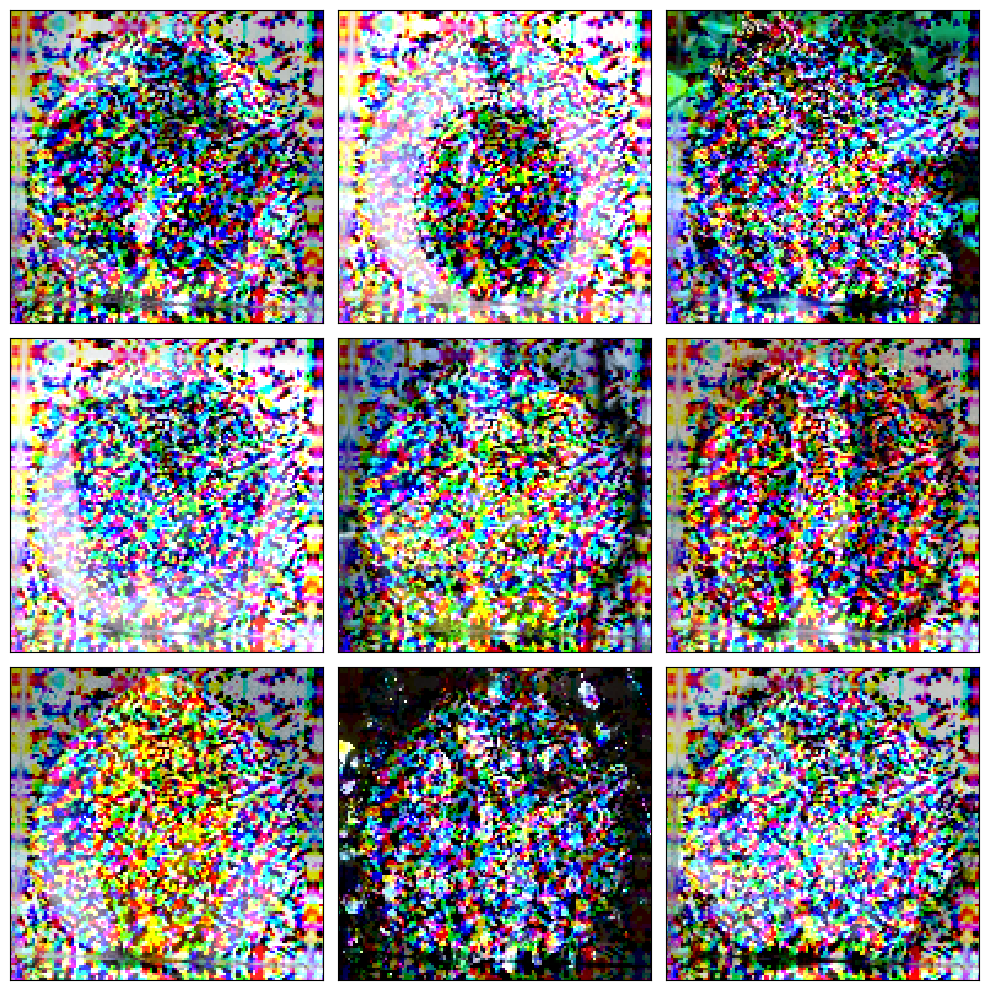

In [ ]:
plot_attacked_images(X_test_adv_uni)

### 3.2.4 GeoDA 

**Model Introduction**:

The Geometric Decision-based Attack (GeoDA) is a type of adversarial attack that perturbs the input data to mislead the classifier without the need for gradient information. It operates in a black-box setting and manipulates the geometry of the input data to cause misclassification. GeoDA attack is particularly suited for situations where the attacker doesn't have access to the model's internals, such as its gradients or architecture. In the experiment, The `estimator` parameter is the classifier to be attacked, and the `x` parameter is the subset of test data to be perturbed. After generating the adversarial examples, the code evaluates the classifier's accuracy on the adversarial test set and computes the average magnitude of the perturbation.

In [ ]:
# GeoDA Attack
attacker_geo = GeoDA(estimator=classifier)

# Generate the adversarial examples
X_test_adv_geo = attacker_geo.generate(x=X_test_subset[:10])

# Evaluate the model on the adversarial test examples
predictions_geo = classifier.predict(X_test_adv_geo)
accuracy_geo = np.sum(np.argmax(predictions_geo, axis=1) == np.argmax(y_test_subset[:10], axis=1)) / len(y_test_subset[:10])
avg_perturbation_geo = np.mean(np.abs((X_test_adv_geo - X_test_subset[:10])))

print(f'Geometric Decision-based Attack: Test Accuracy: {accuracy_geo}, Average Perturbation: {avg_perturbation_geo}')


GeoDA - samples:   0%|          | 0/10 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

Geometric Decision-based Attack: Test Accuracy: 0.2, Average Perturbation: 0.03730658146707297


**Result Analysis**:

The Geometric Decision-based Attack (GeoDA) has achieved a moderate level of success against the classifier trained on the mineral image dataset. The test accuracy has been reduced to 20%, indicating that the GeoDA attack has been successful in causing misclassifications for a subset of the tested samples. GeoDA's strength lies in its ability to manipulate the geometry of the input data to deceive the classifier, even in black-box settings where the attacker lacks knowledge of the model's internal architecture or gradients. The attack does not rely on gradient information, making it a valuable tool in scenarios where such information is inaccessible.

However, the reported average perturbation of approximately 0.037 suggests that the changes made by the GeoDA attack are noticeable, but potentially still subtle to the human eye. This indicates that the attack manages to cause misclassification while keeping the perturbations within a reasonable range. Nevertheless, the relatively lower test accuracy compared to the original model's performance indicates that the classifier is partially resilient to the GeoDA attack. Further analysis is necessary to determine the specific characteristics of the dataset and the classifier that contribute to this partial resilience, and to explore potential strategies to enhance the model's robustness against GeoDA attacks, such as adversarial training or incorporating geometry-based defenses.

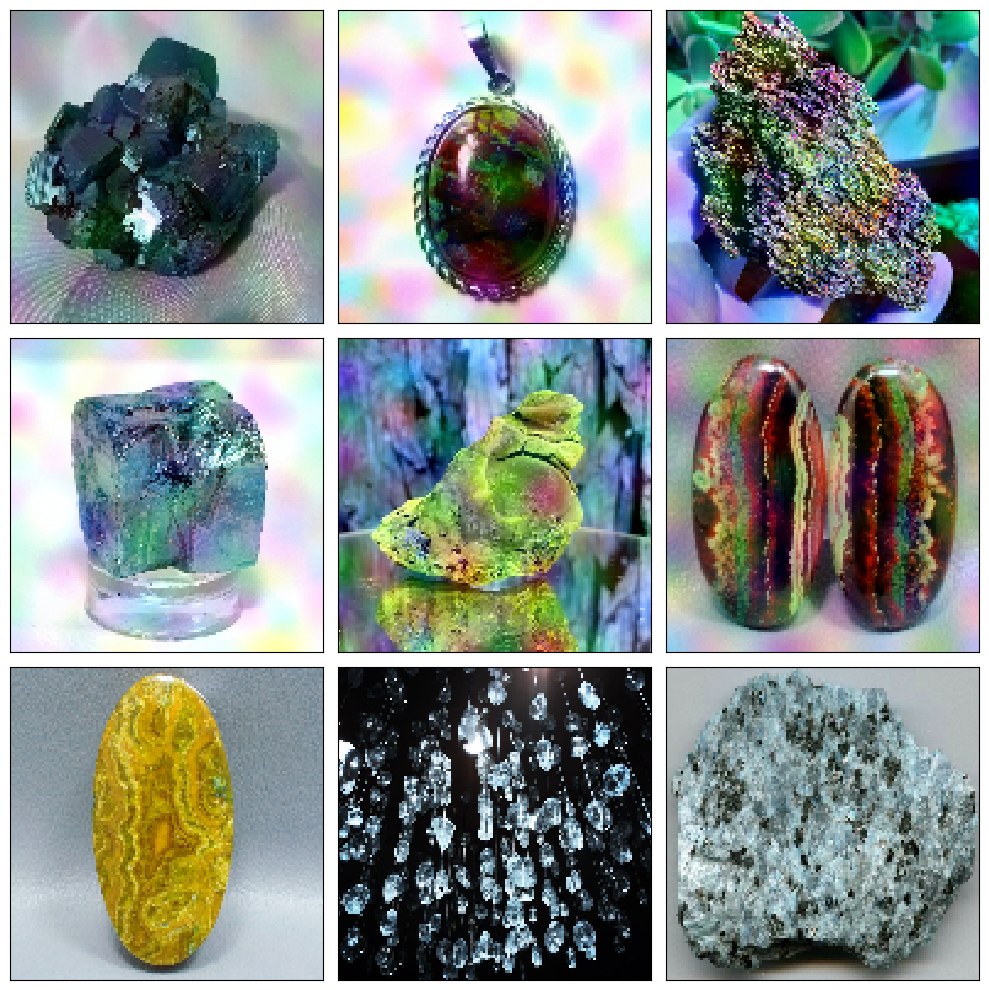

In [ ]:
plot_attacked_images(X_test_adv_geo)